In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import pickle

import numpy as np
import random

import seaborn as sns

# Датасет

In [2]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [3]:
transform_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train = datasets.CIFAR10('../data/CIFAR10/train', train=True, download=True, transform=transform_list)
test = datasets.CIFAR10('../data/CIFAR10/test', train=False, download=True, transform=transform_list)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

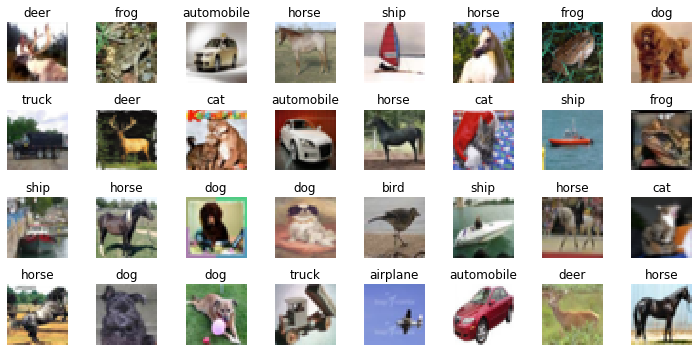

In [5]:
batch, labels = next(iter(trainset))

f = plt.figure(figsize=(10, 5))

n_rows = 8
n_cols = 4

for i in range(n_cols*n_rows):
    ax = f.add_subplot(n_cols, n_rows, i+1)
    ax.axis('off')
    plt.imshow(batch[i].permute(1,2,0)/2+.5)
    plt.title(cifar10_classes[int(labels[i])])
    
plt.tight_layout()

# Свёрточный классификатор

In [325]:
def conv_block(in_ch, inner_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, inner_ch, kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(.1),
        nn.Conv2d(inner_ch, out_ch, kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(.1),
        nn.MaxPool2d(2, 2),
        nn.Dropout(.25)
    )

def fc_block(in_f, inner_f, *args, **kwargs):
    return nn.Sequential(
        nn.Linear(in_f, inner_f),
        nn.LeakyReLU(.1),
        nn.Dropout(0.5),
        nn.Linear(inner_f, 10),
        #nn.Softmax(dim=1)
    )

def init_weights(block):
    for l in block:
        '''
        По неясной причине правильная инициализация ухудшает качество обучения,
        замедляет сходимость.
        
        if isinstance(l, nn.Conv2d):
            nn.init.kaiming_uniform_(l.weight, .1)
        elif isinstance(l, nn.Linear):
            nn.init.xavier_uniform_(l.weight)'''
        if isinstance(l, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(l.weight)

class Model(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = conv_block(3, 16, 32)
        init_weights(self.conv1)
        self.conv2 = conv_block(32, 32, 64)
        init_weights(self.conv2)
        
        self.fc = fc_block(64*8*8, 256)
        init_weights(self.fc)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = x.view(-1, 64*8*8)
        
        x = self.fc(x)
        
        return x
    
    def conv1_1(self, x):
        x = self.conv1[0](x)
        x = self.conv1[1](x)
        
        return x
    
    def conv1_2(self, x):
        x = self.conv1_1(x)
        
        x = self.conv1[2](x)
        x = self.conv1[3](x)
        
        return x
    
    def conv2_1(self, x):
        x = self.conv1(x)
        
        x = self.conv2[0](x)
        x = self.conv2[1](x)
        
        return x
    
    def conv2_2(self, x):
        x = self.conv2_1(x)
        
        x = self.conv2[2](x)
        x = self.conv2[3](x)
        
        return x

In [326]:
def evaluate_accuracy(model, testset):
    '''
    Evaluates both model accuracy and loss on a given dataset
    
    model - model to evaluate
    testset - dataset to evaluate model on
    
    Returns tuple (accuracy, mean loss)
    '''
    correct = 0
    
    with torch.no_grad():
        for batch in testset:
            images, labels = batch
            output = model(images.cuda())            
            correct += sum(output.argmax(axis=1) == labels.cuda())
                
    return correct.cpu().numpy().item()/testset.dataset.data.shape[0]

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

In [199]:
%%time

model = Model().cuda()
epochs = 25

optimizer = optim.Adamax(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss()

for e in range(epochs):
        
    model.train()
       
    print('Epoch: %s lr: %.4f' % (str(e+1), get_lr(optimizer)))
    
    for i, (batch, labels) in enumerate(trainset):
        
        optimizer.zero_grad()
        output = model(batch.cuda())
        
        loss = criterion(output, labels.cuda())*128
        loss.backward()
        
        optimizer.step()
        
    else:
        model.eval()
        print('Accuracy: %.3f' % evaluate_accuracy(model, testset))

NameError: name 'Model' is not defined

После того, как мы обучили классификатор, постараемся понять, как он работает. Для этого найдём изображения, доставляющие максимум активации свёрточным фильтрам. Их можно понимать как графические паттерны, которые нейросеть пытается найти на картинке, и использовать их как признаки.

In [ ]:
def get_max_images(func, neuron_count):

    max_imgs = []

    for neuron_n in range(neuron_count):
        # Оптимизируемое изображение.
        # Иницализируется случайно.
        img = torch.tensor((np.random.rand(1, 3, 32, 32) - .5)/.5, dtype=torch.float, requires_grad=True, device='cuda')
        # Трактуем изображение как веса, который надо оптимизировать.
        optimizer = optim.Adam([img], lr=5e-3)

        for i in range(1000):
            optimizer.zero_grad()
            img_tanh = torch.tanh(img)
            output = func(img_tanh)[0][neuron_n]
            # Функция потерь - средний уровень значений пикселей в featurte map.
            # Большие значения говорят о том, что сеть нашла какой-то паттерн.
            loss = -torch.mean(output)
            loss.backward()    
            optimizer.step()

        max_imgs.append(img_tanh[0].permute(1,2,0).cpu().detach().numpy())
        
    return max_imgs

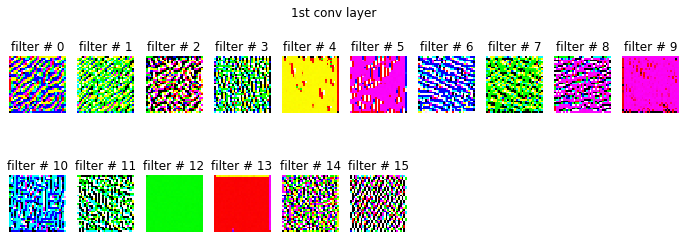

In [11]:
# Получим картинки, максимизирующие активации фильтров первого свёрточного слоя (16 фильтров)
max_images_1_1 = get_max_images(model.conv1_1, 16)

f = plt.figure(figsize=(12, 4))
f.suptitle('1st conv layer')
for i in range(16):
    f.add_subplot(np.ceil(len(max_images_1_1)/10), 10, i+1)
    plt.imshow(max_images_1_1[i]/2+.5)
    plt.axis('off')
    plt.title('filter # %d' % i)

Некоторые фильры реагируют просто на цвета. Из проще всего интерпретировать - признак "есть ли на картинке красный". Есть и другие, более сложны паттерны - цветная рябь, и нечно похожее на линии. Запомним несколько фильтров, на которые хотим посмотреть подробнее.

In [ ]:
filters_toshow = {}

filters_toshow['conv1_1'] = [3, 9, 13]

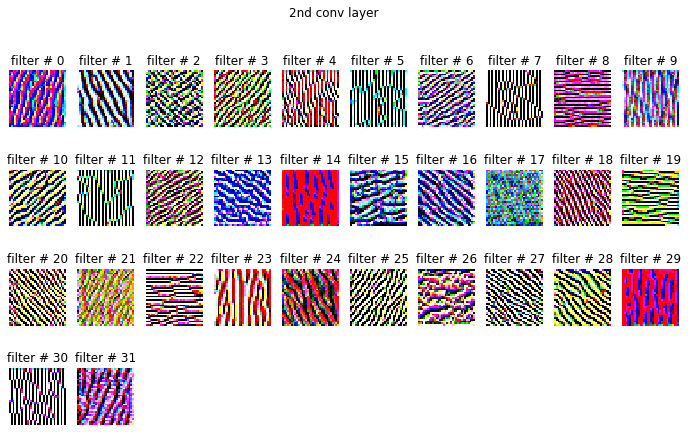

In [13]:
# Получим картинки, максимизирующие активации фильтров второго свёрточного слоя (32 фильтра)
max_images_1_2 = get_max_images(model.conv1_2, 32)

f = plt.figure(figsize=(12, 7))
f.suptitle('2nd conv layer')
for i in range(32):
    f.add_subplot(np.ceil(len(max_images_1_2)/10), 10, i+1)
    plt.imshow(max_images_1_2[i]/2+.5)
    plt.axis('off')
    plt.title('filter # %d' % i)

Тут видны фильтры, выделяющие вертикальные, горизонтальные, и наклонные линии разных цветов, а также разнообразная "рябь".

In [ ]:
filters_toshow['conv1_2'] = [0, 5, 6, 9, 27]

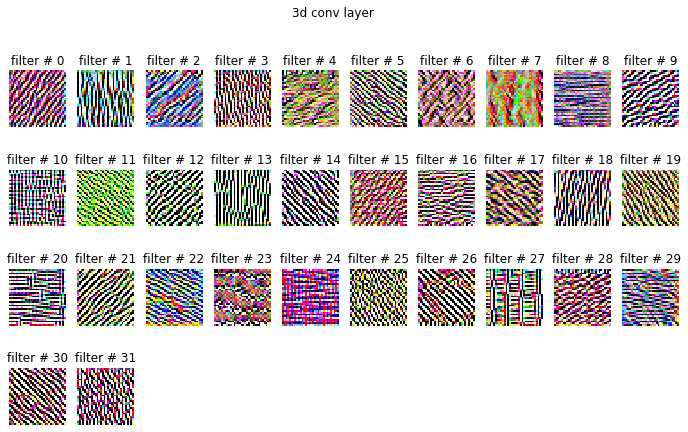

In [15]:
# Получим картинки, максимизирующие активации фильтров третьего свёрточного слоя (32 фильтра)
max_images_2_1 = get_max_images(model.conv2_1, 32)

f = plt.figure(figsize=(12, 7))
f.suptitle('3d conv layer')
for i in range(32):
    f.add_subplot(np.ceil(len(max_images_2_1)/10), 10, i+1)
    plt.imshow(max_images_2_1[i]/2+.5)
    plt.axis('off')
    plt.title('filter # %d' % i)

В этом слое видим полоски более сложной структуры, сочетающей как вертикальные, так и горизонтальные линии, и шум более сложной структуры.

In [ ]:
filters_toshow['conv2_1'] = [9, 22, 26, 27]

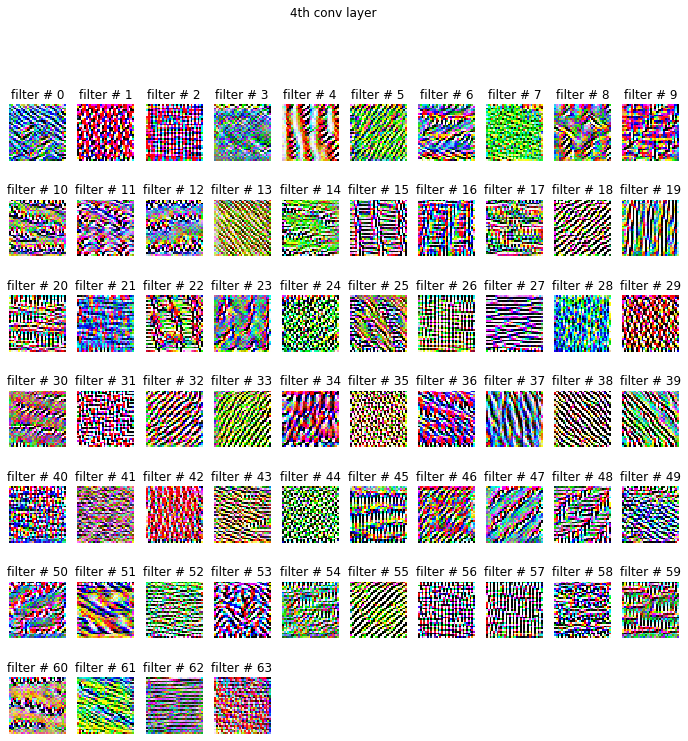

In [17]:
# Получим картинки, максимизирующие активации фильтров четвёртого свёрточного слоя (64 фильтра)
max_images_2_2 = get_max_images(model.conv2_2, 64)

f = plt.figure(figsize=(12, 12))
f.suptitle('4th conv layer')
for i in range(64):
    f.add_subplot(np.ceil(len(max_images_2_2)/10), 10, i+1)
    plt.imshow(max_images_2_2[i]/2+.5)
    plt.axis('off')
    plt.title('filter # %d' % i)

Тут много совсем причудливых картинок. Сложно соотнести их с какими-либо классами датасета, или геометрическими особенностями объектов.

Теперь посмотрим, как выглядят картинки в "объективе" этих свёрточных фильтров. Какие признаки фильтры выделяют в картинках?

In [ ]:
filters_toshow['conv2_2'] = [14, 30, 44, 61]

In [ ]:
FILTERS_TOSHOW = sum([len(filter_idx) for filter_idx in filters_toshow.values()])
COLUMNS = FILTERS_TOSHOW+1

def plot_filters():
    '''
    Plot convolutional filters
    '''

    f = plt.figure(figsize=(20, 4))

    layer_name_to_max_images = {
      'conv1_1': max_images_1_1, 
      'conv1_2': max_images_1_2, 
      'conv2_1': max_images_2_1, 
      'conv2_2': max_images_2_2}

    f.add_subplot(1, COLUMNS, 1)
    plt.imshow(np.ones((32, 32, 3)))
    plt.axis('off')

    img_ix = 2

    for layer_name, filters in filters_toshow.items():
        for filter_ix in filters:
            f.add_subplot(1, COLUMNS, img_ix)
            img_ix += 1
            plt.imshow(layer_name_to_max_images[layer_name][filter_ix]/2+.5)
            plt.axis('off')
            plt.title('%s\nFilter # %d' % (layer_name, filter_ix))

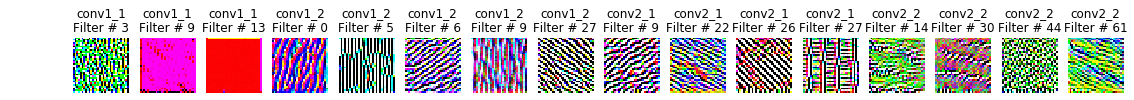

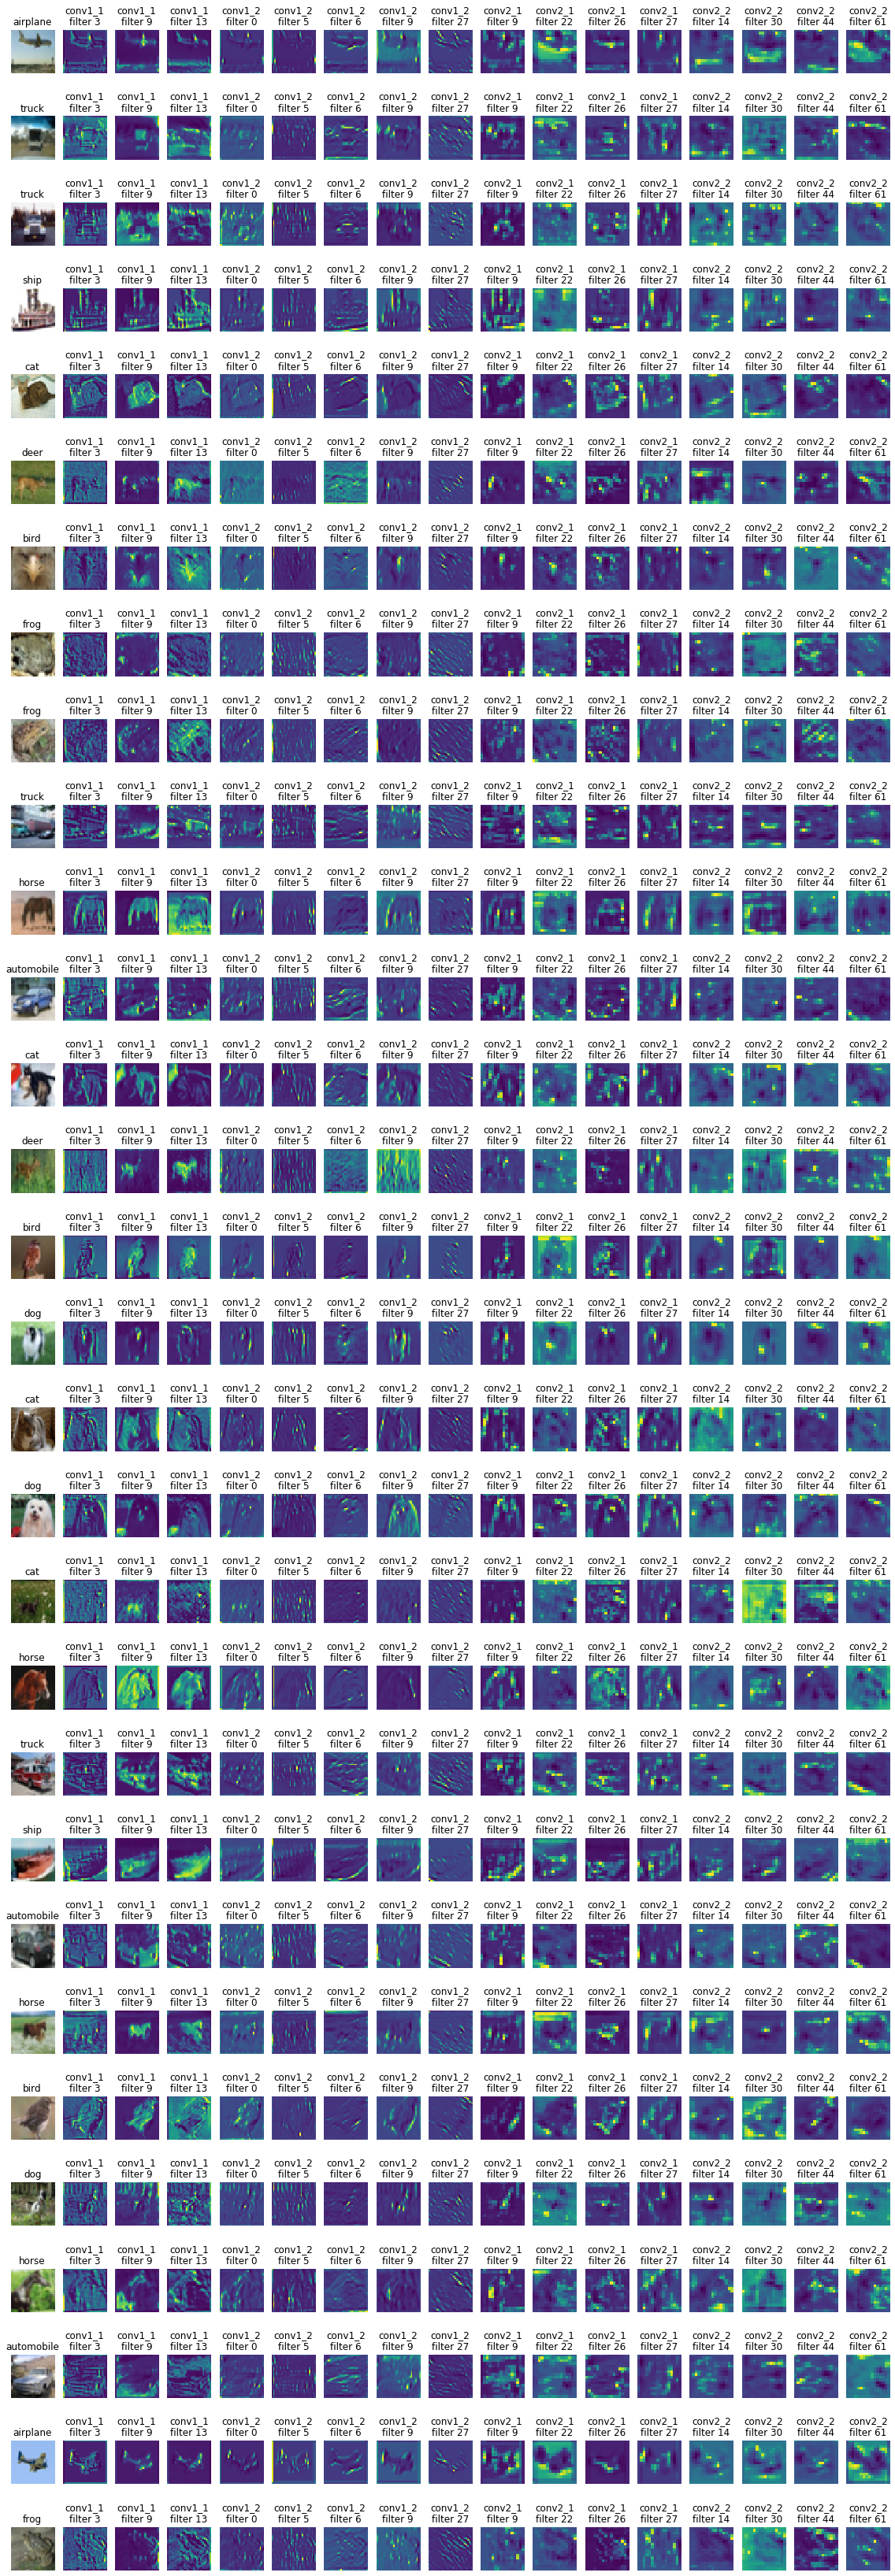

In [20]:
IMG_TOSHOW = 30

plot_filters()

batch, labels = next(iter(trainset))
f = plt.figure(figsize=(20, 60))

plot_index = 0

for img_ix in range(IMG_TOSHOW):
    # Отрисовка оригинальных изображений
    f.add_subplot(IMG_TOSHOW, COLUMNS, img_ix*COLUMNS+1)
    plt.imshow(batch[img_ix, :, :, :].permute(1,2,0)/2+.5)
    plt.axis('off')
    plt.title(cifar10_classes[labels[img_ix]])

    # Оригинальные изображения, пропущенные через фильтр
    for k, v in filters_toshow.items():
        for neuron_n in v:
            plot_index += 1
            f.add_subplot(IMG_TOSHOW, COLUMNS, img_ix*COLUMNS+1+plot_index)
            plt.imshow(getattr(model, k)(batch[img_ix:img_ix+1, :, :, :].cuda())[0][neuron_n].cpu().detach())
            plt.axis('off')
            plt.title(k + '\nfilter %d' % neuron_n)

    plot_index = 0

Просто интерпретировать одноцветные фильтры, а также фильтры с горизонтальными, вертикальными и наклонными полосами. Однако, мне не удаётся, глядя на изображение, понять, какие его части выделит фильтр с какой-нибудь сложной структурой.

Теперь попробуем найти изображения, представляющие собой идельные примеры каждого из классов для нейросети. Для этого в качестве функции потерь будем использовать уверенность сети в том, что перед нами изображение выбранного класса.

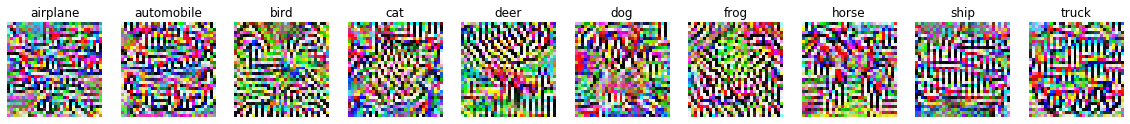

In [244]:
max_imgs = []

for neuron_n in range(10):
    img = torch.tensor((np.random.rand(1, 3, 32, 32) - .5)/.5, dtype=torch.float, requires_grad=True, device='cuda')
    optimizer = optim.Adam([img], lr=5e-3)

    for i in range(500):
        optimizer.zero_grad()
        img_tanh = torch.tanh(img)
        loss = -model(img_tanh)[0][neuron_n]
        loss.backward()    
        optimizer.step()

    max_imgs.append(img_tanh[0].permute(1,2,0).cpu().detach().numpy())

f = plt.figure(figsize=(20, 2))
for i in range(10):
    f.add_subplot(np.ceil(len(max_imgs)/10), 10, i+1)
    plt.imshow(max_imgs[i]/2+.5)
    plt.title(cifar10_classes[i])
    plt.axis('off')

Можно сказать только то, что эти изображения для человека мало похожи на объекты выбранных классов. Это говорит о том, что нейросети хоть и пытаются выучить человеческие представления о распределении пикселей на классах, но получается это далеко не идеально.

Однако, при должной фантазии тут можно всё-таки опознать классы. Олень, например, довольно похож.

Убедимся, что действительно нашли изображения, которые идеально бы распознавались как объекты соответствующих классов.

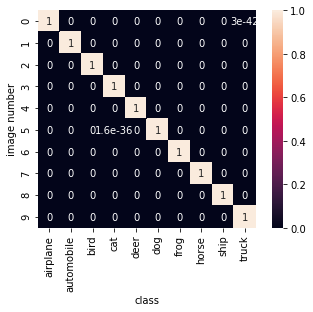

In [245]:
output = model(torch.tensor(np.array(max_imgs), device='cuda').permute(0, 3, 1, 2))
smax = nn.Softmax(dim=1)(output).cpu().detach()
ax = sns.heatmap(smax, square=True, annot=True)
ax.set_xticklabels(cifar10_classes)
plt.xticks(rotation='vertical')
plt.xlabel('class')
plt.ylabel('image number')

plt.show()

Теперь посмотрим через "оптику" свёрточных фильтров на "идеальные" изображения.

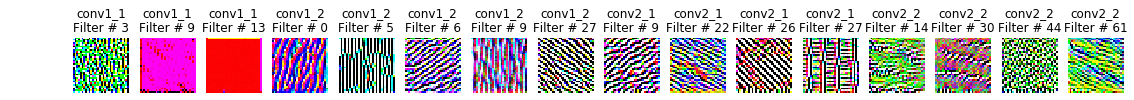

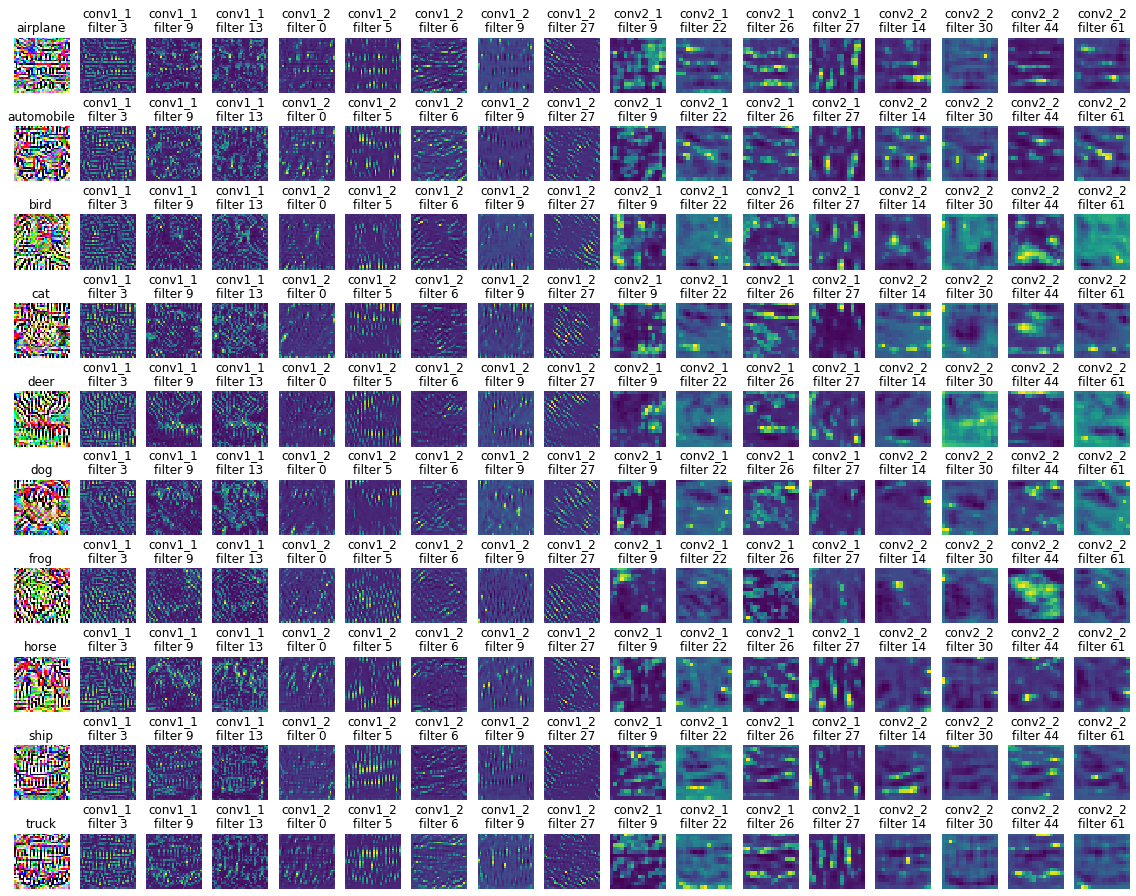

In [40]:
IMG_TOSHOW = 10
FILTERS_TOSHOW = sum([len(filter_idx) for filter_idx in filters_toshow.values()])
COLUMNS = FILTERS_TOSHOW+1

plot_filters()

batch = torch.tensor(max_imgs, device='cuda').permute(0, 3, 1, 2)
f = plt.figure(figsize=(20, 16))

plot_index = 0

for img_ix in range(IMG_TOSHOW):
    f.add_subplot(IMG_TOSHOW, COLUMNS, img_ix*COLUMNS+1)
    plt.imshow(batch[img_ix, :, :, :].permute(1,2,0).cpu().detach()/2+.5)
    plt.axis('off')
    plt.title(cifar10_classes[img_ix])

    for k, v in filters_toshow.items():
        for neuron_n in v:
            plot_index += 1
            f.add_subplot(IMG_TOSHOW, COLUMNS, img_ix*COLUMNS+1+plot_index)
            plt.imshow(getattr(model, k)(batch[img_ix:img_ix+1, :, :, :])[0][neuron_n].cpu().detach())
            plt.axis('off')
            plt.title(k + '\nfilter %d' % neuron_n)

    plot_index = 0

Честно говоря, у меня не получается сделать какие-то новые выводы...

Попробуем теперь взять какое-то изображение, и немного изменить его, так, чтобы нейросеть думала, что это объект другого класса.

In [ ]:
dog_img = test[16][0]
airplane_img = dog_img.clone()

(-0.5, 31.5, 31.5, -0.5)

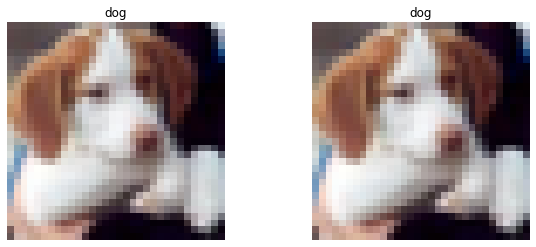

In [247]:
f = plt.figure(figsize=(10, 4))
f.add_subplot(121)
plt.imshow(dog_img.permute(1,2,0)/2+.5)
plt.title(cifar10_classes[model(dog_img.view(1,3,32,32).cuda()).argmax(axis=1)])
plt.axis('off')
f.add_subplot(122)
plt.imshow(airplane_img.permute(1,2,0)/2+.5)
plt.title(cifar10_classes[model(airplane_img.view(1,3,32,32).cuda()).argmax(axis=1)])
plt.axis('off')

In [248]:
airplane_img = airplane_img.view(1,3,32,32).numpy()
airplane_img = torch.tensor(airplane_img, dtype=torch.float32, requires_grad=True, device='cuda')

optimizer = optim.Adam([airplane_img], lr=5e-3)

for i in range(1000):
    optimizer.zero_grad()
    airplane_img_tanh = torch.tanh(airplane_img)
    if nn.Softmax(dim=1)(model(airplane_img_tanh))[0][0] >= .85:
        print('Stopped as iter %d' % i)
        break
    loss = -model(airplane_img_tanh)[0][0]
    loss.backward()
    optimizer.step()    

airplane_img = airplane_img[0].cpu().detach()
airplane_img_tanh = airplane_img_tanh[0].cpu().detach()

Stopped as iter 18


(-0.5, 31.5, 31.5, -0.5)

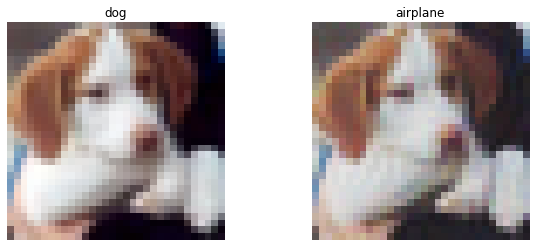

In [249]:
f = plt.figure(figsize=(10, 4))
f.add_subplot(121)
plt.imshow(dog_img.permute(1,2,0)/2+.5)
plt.title(cifar10_classes[model(dog_img.view(1,3,32,32).cuda()).argmax(axis=1)])
plt.axis('off')
f.add_subplot(122)
plt.imshow(airplane_img_tanh.detach().permute(1,2,0)/2+.5)
plt.title(cifar10_classes[model(airplane_img_tanh.view(1,3,32,32).cuda()).argmax(axis=1)])
plt.axis('off')

Изменения почти не заметны глазом, но классификатор теперь даёт 85% уверенности, что перед нами самолёт, а не собака)

# Свёрточный автокодировщик

In [190]:
class Encoder(nn.Module):
    def __init__(self, code_size=32):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3,3), stride=2, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight, a=.1)        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=2, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight, a=.1)        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=2, padding=1)
        nn.init.kaiming_uniform_(self.conv3.weight, a=.1)        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=2, padding=1)
        nn.init.kaiming_uniform_(self.conv4.weight, a=.1)
        self.dense = nn.Linear(2*2*128, code_size)
        nn.init.xavier_uniform_(self.dense.weight)
        
    def forward(self, x):
        
        x = nn.modules.activation.LeakyReLU(.1)(self.conv1(x))
        x = nn.modules.activation.LeakyReLU(.1)(self.conv2(x))
        x = nn.modules.activation.LeakyReLU(.1)(self.conv3(x))
        x = nn.modules.activation.LeakyReLU(.1)(self.conv4(x))
        
        x = x.view(-1, 2*2*128)
        
        x = self.dense(x)
        x = nn.modules.activation.Tanh()(x)
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, code_size=32):
        
        super().__init__()
        
        self.dense = nn.Linear(code_size, 128*2*2)
        
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        nn.init.kaiming_uniform_(self.deconv1.weight, a=.1)
        
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        nn.init.kaiming_uniform_(self.deconv2.weight, a=.1)
        
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        nn.init.kaiming_uniform_(self.deconv3.weight, a=.1)
        
        self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)
        nn.init.xavier_uniform_(self.deconv4.weight)
        
    def forward(self, x):
        
        x = self.dense(x)
        x = x.view(-1,128,2,2)
        
        x = nn.modules.activation.LeakyReLU(.1)(self.deconv1(x))
        x = nn.modules.activation.LeakyReLU(.1)(self.deconv2(x))
        x = nn.modules.activation.LeakyReLU(.1)(self.deconv3(x))
        x = nn.modules.activation.Tanh()(self.deconv4(x))
       
        return x
    
class Codec(nn.Module):
    def __init__(self, code_size=32):
        
        super().__init__()
        
        self.E = Encoder(code_size)
        self.D = Decoder(code_size)
        
    def forward(self, x):
        
        x = self.E(x)
        x = self.D(x)
        
        return x

In [227]:
codec = Codec(512).cuda()

In [ ]:
def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

EPOCHS = 25
optimizer = optim.Adamax(codec.parameters(), lr=5e-3)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(trainset), gamma=0.9)

for e in range(EPOCHS):
    for i, (batch, _) in enumerate(trainset):
        optimizer.zero_grad()
        output = codec(batch.cuda())
        loss = criterion(output, batch.cuda())
        loss.backward()
        optimizer.step()
        scheduler.step()
    print('epoch: {}, loss: {:.4f}, lr: {:.4f}'.format(e+1, loss.cpu().detach().numpy(), get_lr(optimizer)))

epoch: 1, loss: 0.0475, lr: 0.0045
epoch: 2, loss: 0.0377, lr: 0.0041
epoch: 3, loss: 0.0356, lr: 0.0036
epoch: 4, loss: 0.0283, lr: 0.0033
epoch: 5, loss: 0.0256, lr: 0.0030
epoch: 6, loss: 0.0224, lr: 0.0027
epoch: 7, loss: 0.0216, lr: 0.0024
epoch: 8, loss: 0.0215, lr: 0.0022
epoch: 9, loss: 0.0215, lr: 0.0019
epoch: 10, loss: 0.0184, lr: 0.0017
epoch: 11, loss: 0.0187, lr: 0.0016
epoch: 12, loss: 0.0171, lr: 0.0014
epoch: 13, loss: 0.0164, lr: 0.0013
epoch: 14, loss: 0.0152, lr: 0.0011
epoch: 15, loss: 0.0170, lr: 0.0010


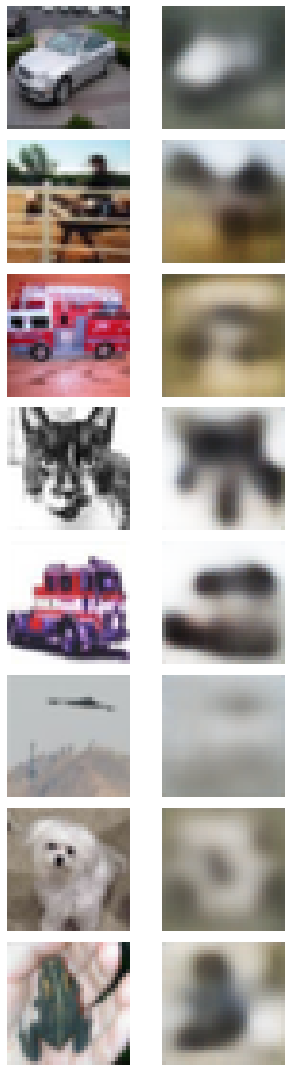

In [226]:
batch, labels = next(iter(trainset))
batch_processed = codec(batch.cuda()).cpu().detach()

f = plt.figure(figsize=(5, 15))

n_rows = 8

for i in range(n_rows):
    ax = f.add_subplot(n_rows, 2, i*2+1)
    ax.axis('off')
    plt.imshow(batch[i].permute(1,2,0)/2+.5)
    
    ax = f.add_subplot(n_rows, 2, i*2+2)
    ax.axis('off')
    plt.imshow(batch_processed[i].permute(1,2,0)/2+.5)
    
plt.tight_layout()

In [223]:
max_imgs = []

for neuron_n in range(512):
    # Оптимизируемое изображение.
    # Иницализируется случайно.
    img = torch.tensor((np.random.rand(1, 3, 32, 32) - .5)/.5, dtype=torch.float, requires_grad=True, device='cuda')
    # Трактуем изображение как веса, который надо оптимизировать.
    optimizer = optim.Adam([img], lr=5e-3)

    for i in range(1000):
        optimizer.zero_grad()
        img_tanh = torch.tanh(img)
        output = codec.E(img_tanh)[0][neuron_n]
        # Функция потерь - средний уровень значений пикселей в featurte map.
        # Большие значения говорят о том, что сеть нашла какой-то паттерн.
        loss = -torch.mean(output)
        loss.backward()    
        optimizer.step()

    max_imgs.append(img_tanh[0].permute(1,2,0).cpu().detach().numpy())

return max_imgs

KeyboardInterrupt: 

In [ ]:
f = plt.figure(figsize=(12, 12))
f.suptitle('4th conv layer')
for i in range(64):
    f.add_subplot(np.ceil(len(max_imgs)/10), 10, i+1)
    plt.imshow(max_imgs[i]/2+.5)
    plt.axis('off')
    plt.title('filter # %d' % i)